# RAG (Retrieval-Augmented Generation) QA System

##Overview
The project aims to develop a sophisticated Retrieval-Augmented Generation (RAG) system for question answering (QA) using state-of-the-art natural language processing (NLP) techniques and tools. The system combines document retrieval and language generation to provide accurate and contextually relevant answers to user queries from a corpus of PDF documents. This project leverages the LangChain framework and Cohere's API to build an efficient and robust QA pipeline.

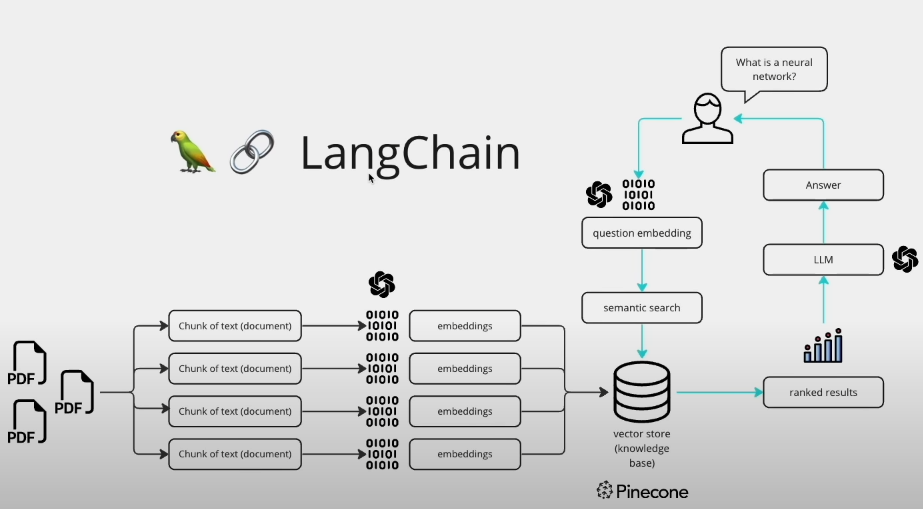

## Install necessary packages

In [1]:
!pip install langchain-community pypdf chromadb unstructured['pdf'] cohere
!pip install --upgrade --quiet  cohere
!pip install langchain_cohere

## Import necessary libraries

In [2]:
import os
from getpass import getpass
from langchain.document_loaders import UnstructuredPDFLoader
from langchain_community.embeddings import CohereEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_community.llms import Cohere
from langchain.chains import RetrievalQA

## Set the Cohere API key
* https://cohere.com/

In [3]:
os.environ["COHERE_API_KEY"] = getpass("Cohere API Key:")

Cohere API Key:··········


## Mount Google Drive to access PDF files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Specify the path to the PDF files

In [5]:
pdf_file_paths = ['/content/drive/MyDrive/Test_Dataset.pdf']

## Load documents from the PDF files

In [6]:
documents = []
for path in pdf_file_paths:
    loader = UnstructuredPDFLoader(path)
    documents.extend(loader.load())

## Initialize the embedding function using Cohere

In [7]:
embedding_function = CohereEmbeddings()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `CohereEmbeddings` was deprecated in LangChain 0.0.30 and will be removed in 0.3.0. An updated version of the class exists in the langchain-cohere package and should be used instead. To use it run `pip install -U langchain-cohere` and import as `from langchain_cohere import CohereEmbeddings`.
  warn_deprecated(


## Initialize the vector store to store document embeddings

In [8]:
vector_store = Chroma(embedding_function=embedding_function)

## Initialize an in-memory document store

In [9]:
document_store = InMemoryStore()

## Define text splitters for parent and child documents

In [10]:
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=128)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=256, chunk_overlap=64)

## Initialize the parent document retriever

In [11]:
retriever = ParentDocumentRetriever(
    vectorstore=vector_store,
    docstore=document_store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

## Add loaded documents to the retriever

In [12]:
retriever.add_documents(documents)

### Testing Document retriever

In [13]:
query = "How can you get started with IBM watsonx.data today?"

In [14]:
relevant_context = retriever.get_relevant_documents(query)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [15]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [16]:
pretty_print_docs(relevant_context)

Document 1:

How can you get started with IBM watsonx.data today?

Try watsonx.data yourself with a free trial. Are you interested in learning more about any of our upcoming product updates? Join our upcoming webinar recapping our Think announcements or book a meeting with an IBM watsonx.data product specialist.
----------------------------------------------------------------------------------------------------
Document 2:

Create a knowledge base to enhance the relevance and precision of your AI

Using your trusted, governed data is essential for the accuracy and relevance of AI applications. That is why we recently launched an integrated vector database based on the open source Milvus in IBM watsonx.data. Now, watsonx clients can unify, curate and prepare vectorized embeddings for their generative AI applications at scale across their trusted, governed data. This helps enhance the relevance and precision of AI outputs, including chatbots, personalized recommendation systems and image

## Initialize the compressor using Cohere for re-ranking

In [17]:
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

### Testing Cohere Re-ranking compression retriever

In [18]:
compressed_docs = compression_retriever.invoke(query)
pretty_print_docs(compressed_docs)

Document 1:

How can you get started with IBM watsonx.data today?

Try watsonx.data yourself with a free trial. Are you interested in learning more about any of our upcoming product updates? Join our upcoming webinar recapping our Think announcements or book a meeting with an IBM watsonx.data product specialist.
----------------------------------------------------------------------------------------------------
Document 2:

Create a knowledge base to enhance the relevance and precision of your AI

Using your trusted, governed data is essential for the accuracy and relevance of AI applications. That is why we recently launched an integrated vector database based on the open source Milvus in IBM watsonx.data. Now, watsonx clients can unify, curate and prepare vectorized embeddings for their generative AI applications at scale across their trusted, governed data. This helps enhance the relevance and precision of AI outputs, including chatbots, personalized recommendation systems and image

## Initialize the Cohere language model with a specific temperature

In [19]:
llm = Cohere(temperature=0)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Cohere` was deprecated in LangChain 0.1.14 and will be removed in 0.3.0. An updated version of the class exists in the langchain-cohere package and should be used instead. To use it run `pip install -U langchain-cohere` and import as `from langchain_cohere import Cohere`.
  warn_deprecated(


## Create a RetrievalQA chain using the language model and the compression retriever

In [20]:
chain = RetrievalQA.from_chain_type(
    llm=llm, retriever=compression_retriever
)

## Run the QA chain

In [21]:
query = "How can you get started with IBM watsonx.data today?"
chain({"query": query})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


{'query': 'How can you get started with IBM watsonx.data today?',
 'result': ' You can get started with IBM watsonx.data today by taking advantage of the free trial offer, or you could attend a webinar recapping product updates. You can also schedule a meeting with a product specialist. \n\nIBM watsonx.data is an integrated vector database based on the open source Milvus, which aims to help clients curate and prepare vectorized embeddings for their generative AI applications at scale across their trusted, governed data. '}

In [22]:
query = "summary"
chain({"query": query})

{'query': 'summary',
 'result': " Watsonx.data has enhanced its performance and data management for AI through the use of Presto C++ v0.286 and a query optimizer on IBM Storage Fusion HCI. \nThis has enabled it to outperform its competitors, such as Databricks' Photon engine, in terms of price-performance. \nThis is demonstrated by its performance at less than 60% of the cost in public 100 TB TPC-DS query benchmarks. \n\nIBM maintains key developers in the Velox project, contributes to the development of Presto 2.0, and has supported the Parquet and Iceberg readers and file system support. In addition, the query optimizer uses enterprise-proven query technology with advanced query rewriting and cost-based optimization techniques. "}